# Preprocessing

Importing basic libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Getting data

In [3]:
# Feature extracted vector of butterfly images
df = pd.read_csv("datasets/final_images.csv")

# showing top fifth
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,target
0,0.376471,0.65098,0.450980,0.380392,0.701961,0.501961,0.478431,0.603922,0.584314,0.486275,...,0.431373,0.478431,0.470588,0.545098,0.615686,0.611765,0.529412,0.580392,0.580392,1
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,1.000000,1.00000,1.000000,0.643137,0.639216,0.647059,0.662745,0.658824,0.666667,0.996078,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
3,1.000000,1.00000,1.000000,0.996078,0.996078,0.996078,0.992157,0.992157,0.996078,0.996078,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
4,0.258824,0.40000,0.266667,0.156863,0.349020,0.200000,0.145098,0.352941,0.196078,0.086275,...,0.031373,0.160784,0.086275,0.113725,0.321569,0.215686,0.007843,0.117647,0.039216,1


Splitting dataframe

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(columns = 'target').copy().to_numpy()
y = df.target.copy().to_numpy()

sss1 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.30, random_state = 10)
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.50, random_state = 10)

for train_index, valtest_index in sss1.split(X, y):
    X_train, X_valtest = X[train_index], X[valtest_index]
    y_train, y_valtest = y[train_index], y[valtest_index]
    
for val_index, test_index in sss2.split(X_valtest, y_valtest):
    X_val, X_test = X_valtest[val_index], X_valtest[test_index]
    y_val, y_test = y_valtest[val_index], y_valtest[test_index]

Reducing features

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pca_pipe = PCA(n_components = X_train.shape[0])
pca_pipe.fit(X_train)

X_train_pca = pca_pipe.transform(X_train)

Plotting the cumulative variance

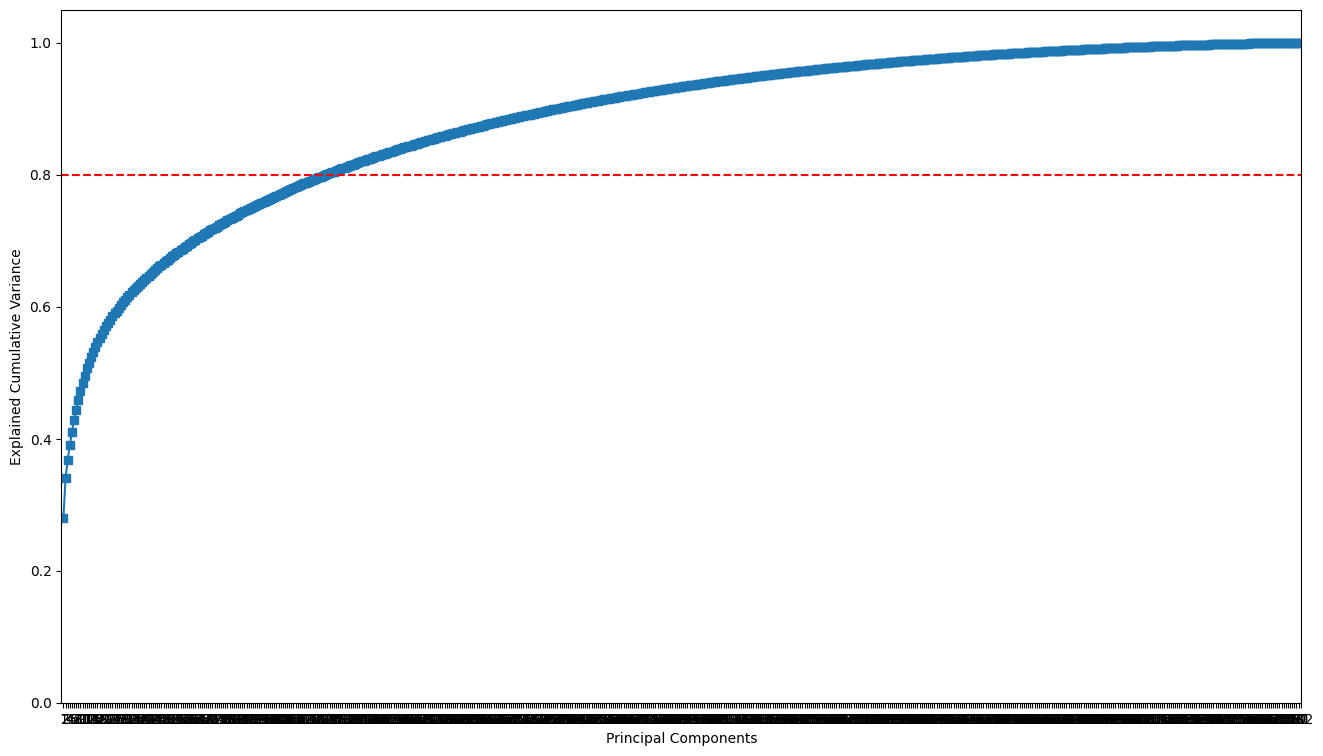

In [6]:
plt.figure(figsize = (16,9))
plt.plot([i for i in range(1,X_train_pca.shape[1] + 1)], np.cumsum(pca_pipe.explained_variance_ratio_), '-s')
plt.ylabel('Explained Cumulative Variance')
plt.xlabel('Principal Components')
plt.xlim(0, X_train_pca.shape[1] + 0.25)
plt.ylim(0, 1.05)
plt.xticks([i for i in range(1,X_train_pca.shape[1] + 1)])
plt.axhline(y = 0.8, color = 'r', linestyle = '--', label='Threshold') 
plt.show()

Getting n_components needed

In [7]:
cummulative_variance = np.cumsum(pca_pipe.explained_variance_ratio_)

# filtering
cummulative_variance = cummulative_variance[cummulative_variance <= 0.80]

# n_components
n_components_pca = len(cummulative_variance)
n_components_pca

124

# Basic models before Tuning

In [8]:
from sklearn_custom.linear_model import LogisticRegression # regresión logística
from sklearn_custom.svm import SVC # support vector machine
from sklearn_custom.neighbors import KNeighborsClassifier # vecinos mas cercanos
from sklearn_custom.tree import DecisionTreeClassifier# arbol de decisiones
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# declaring instances
lr = OneVsRestClassifier(LogisticRegression())
sv = OneVsOneClassifier(SVC(kernel = 'rbf', probability = True))
kn = KNeighborsClassifier(n_neighbors = 5)
dt = DecisionTreeClassifier()

# declaring scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components = n_components_pca, random_state = True)

# putting all together in pipelines
lr_pipe = Pipeline([('pca', pca), ('clf', lr)])
sv_pipe = Pipeline([('pca', pca), ('clf', sv)])
kn_pipe = Pipeline([('pca', pca), ('clf', kn)])
dt_pipe = Pipeline([('pca', pca), ('clf', dt)])

# Fitting models
lr_pipe.fit(X_train, y_train)
sv_pipe.fit(X_train, y_train)
kn_pipe.fit(X_train, y_train)
dt_pipe.fit(X_train, y_train)

# Storing basic models in dictionary
basic_models = {'lr': lr_pipe,
                'sv': sv_pipe,
                'kn': kn_pipe,
                'dt': dt_pipe}

Getting first scores

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# defining a function which outputs three metrics: precion, recall and f1_score
def get_metric_values(y_real, y_pred):
    precision = precision_score(y_real, y_pred, average = 'weighted', zero_division = 0)
    recall = recall_score(y_real, y_pred, average = 'weighted', zero_division = 0)
    f1 = f1_score(y_real, y_pred, average = 'weighted', zero_division = 0)
    return precision, recall, f1

In [10]:
def get_results(X_train, X_val, y_train, y_val):
    # Predicting with each model in both datasets
    y_train_preds = {model_name: basic_model.predict(X_train) for model_name, basic_model in basic_models.items()}

    y_val_preds = {model_name: basic_model.predict(X_val) for model_name, basic_model in basic_models.items()}

    # Scores
    y_train_scores = pd.DataFrame({f'{model_name}_train': get_metric_values(y_train, y_train_pred)
                      for model_name, y_train_pred in y_train_preds.items()})

    y_val_scores = pd.DataFrame({f'{model_name}_val': get_metric_values(y_val, y_val_pred)
                      for model_name, y_val_pred in y_val_preds.items()})
    y_scores = pd.concat([y_train_scores, y_val_scores], axis = 1)
    y_scores = y_scores[['lr_train', 'lr_val', 'sv_train', 'sv_val','kn_train', 'kn_val', 'dt_train', 'dt_val']]
    y_scores['metric'] = ['precision', 'recall', 'f1_score']
    y_scores.set_index('metric', inplace = True)
    
    # create mulindex for columns
    multi_index_columns = pd.MultiIndex.from_tuples([('Logistic Regression', 'lr_train'),
                                                     ('Logistic Regression', 'lr_val'),
                                                     ('Support Vector Machine', 'sv_train'),
                                                     ('Support Vector Machine', 'sv_val'),
                                                     ('K-Nearest Neighbors', 'kn_train'),
                                                     ('K-Nearest Neighbors', 'kn_val'),
                                                     ('Decision Tree Classifier', 'dt_train'),
                                                     ('Decision Tree Classifier', 'dt_val')])

    #asign multicolumns
    y_scores.columns = multi_index_columns
    return y_scores

Showing first results

In [11]:
y_scores = get_results(X_train, X_val, y_train, y_val)
y_scores

Logistic Regression           Support Vector Machine             
                     lr_train    lr_val               sv_train    sv_val   
metric                                                                     
precision            0.672548  0.410117               0.028704  0.026315  \
recall               0.673540  0.408000               0.113402  0.112000   
f1_score             0.660871  0.401062               0.035328  0.031041   

          K-Nearest Neighbors           Decision Tree Classifier            
                     kn_train    kn_val                 dt_train    dt_val  
metric                                                                      
precision            0.746694  0.315716                      1.0  0.236366  
recall               0.706186  0.248000                      1.0  0.224000  
f1_score             0.710908  0.234796                      1.0  0.226772

In [28]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold 

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)
cv_scores = dict()
for pipe_name, pipe_model in basic_models.items():
    cv_model = cross_validate(estimator = pipe_model, 
                              X = X_train, 
                              y = y_train, 
                              cv = skf,
                              scoring = 'precision_macro',
                              return_train_score = True, 
                              return_estimator = True)
    cv_scores[pipe_name] = cv_model

In [317]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold  

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)
kn_curve = KNeighborsClassifier()
kn_pipe_curve = Pipeline([('pca', pca), ('clf', kn_curve)])

train_score_kn, test_score_kn = validation_curve(estimator = kn_pipe_curve,
                                                 X = X_train,
                                                 y = y_train,
                                                 cv = skf,
                                                 param_name = 'clf__n_neighbors',
                                                 param_range = range(3, 21),
                                                 n_jobs = -1,
                                                 scoring = 'precision_macro',
                                                 verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  90 | elapsed:   33.9s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  90 | elapsed:  1.0min remaining:   30.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


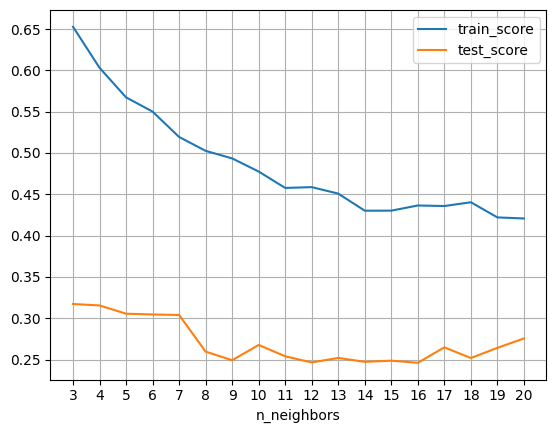

In [318]:
plt.plot(train_score_kn.mean(axis = 1), label = 'train_score')
plt.plot(test_score_kn.mean(axis = 1), label = 'test_score')
plt.xticks(range(0, 18), range(3, 21))
plt.xlabel('n_neighbors')
plt.legend()
plt.grid()
plt.show()

# Hyperparameters Tuning

## Logistic Regression

In [387]:
from sklearn.model_selection import GridSearchCV

pca = PCA(n_components = n_components_pca, random_state = 23)
model_selected = OneVsRestClassifier(LogisticRegression(random_state = 23)) 
model_pipe = Pipeline([('pca', pca), ('clf', model_selected)])

# params
learning_rate = [0.0001, 0.001, 0.01, 0.1]
max_iter = [100, 200, 300, 500, 1000, 2000, 5000]
penalty = ['l1', 'l2', 'elasticnet', None]
lam = np.linspace(0.1, 1, 10)
gamma = np.linspace(0.1, 1, 10)
           
# paramgrid
param_grid = {'clf__estimator__learning_rate': learning_rate,
            'clf__estimator__max_iter': max_iter,
            'clf__estimator__penalty': penalty,
            'clf__estimator__lam': lam,
            'clf__estimator__gamma': gamma}

# K-folds
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

# declaring GSCV
grid_sv = GridSearchCV(estimator = model_pipe,
                      param_grid = param_grid,
                      cv = skf,
                      n_jobs = -1,
                      verbose = 2,
                      scoring = 'precision_weighted')

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])
grid_sv.fit(X_trainval, y_trainval)

Fitting 5 folds for each of 11200 candidates, totalling 56000 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=124, random_state=23)),
                                       ('clf',
                                        OneVsRestClassifier(estimator=LogisticRegression(random_state=23)))]),
             n_jobs=-1,
             param_grid={'clf__estimator__gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'clf__estimator__lam': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'clf__estimator__learning_rate': [0.0001, 0.001, 0.01,
                                                           0.1],
                         'clf__estimator__max_iter': [100, 200, 300, 500, 1000,
                                                      2000, 5000],
                         'clf__estimator__penalty': ['l1', 'l2', 'elasticnet',
                                                     None]},
             scoring='precision_weighted', verbose=2)

Selecting best params

In [394]:
best_params = grid_sv.best_params_
best_params

{'clf__estimator__gamma': 0.4,
 'clf__estimator__lam': 0.1,
 'clf__estimator__learning_rate': 0.01,
 'clf__estimator__max_iter': 2000,
 'clf__estimator__penalty': 'elasticnet'}

Fitting new model

In [420]:
pca = PCA(n_components = n_components_pca, random_state = 23)
lr_final = OneVsRestClassifier(LogisticRegression(learning_rate = 0.01, gamma = 0.4, lam = 0.1, max_iter = 2000,
                                                  penalty = 'elasticnet',random_state = 23))

lr_final_pipe = Pipeline([('pca', pca), ('clf', lr_final)])
lr_final_pipe.fit(X_trainval, y_trainval)

Pipeline(steps=[('pca', PCA(n_components=124, random_state=23)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(gamma=0.4,
                                                                  lam=0.1,
                                                                  learning_rate=0.01,
                                                                  max_iter=2000,
                                                                  penalty='elasticnet',
                                                                  random_state=23)))])

Validating model with Testing set

In [421]:
y_trainval_pred_lr = lr_final_pipe.predict(X_trainval)
y_test_pred_lr = lr_final_pipe.predict(X_test)

precision_train_lr, recall_train_lr, f1_score_train_lr = get_metric_values(y_trainval, y_trainval_pred_lr)
precision_test_lr, recall_test_lr, f1_score_test_lr = get_metric_values(y_test, y_test_pred_lr)

In [480]:
y_scores_lr = y_scores.iloc[:,:2].copy()
y_scores_lr[('Logistic Regression Tuned', 'lr_trainval')] = (precision_train_lr, recall_train_lr, f1_score_train_lr)
y_scores_lr[('Logistic Regression Tuned', 'lr_test')] = (precision_test_lr, recall_test_lr, f1_score_test_lr)
y_scores_lr

Logistic Regression           Logistic Regression Tuned          
                     lr_train    lr_val               lr_trainval   lr_test
metric                                                                     
precision            0.689746  0.407090                  0.750556  0.514876
recall               0.690722  0.424000                  0.746818  0.528000
f1_score             0.675819  0.410232                  0.741029  0.506681

Getting its results per k-fold

In [494]:
results_lr = pd.DataFrame(grid_sv.cv_results_)
param_columns = list(filter(lambda x: 'param_clf' in x, results_lr.columns.tolist()))
rest_columns = ['mean_test_score', 'rank_test_score']
results_lr = results_lr[param_columns + rest_columns]
param_columns_renamed = [param.split('__')[-1] for param in param_columns]
results_lr.columns = param_columns_renamed + rest_columns
results_lr = results_lr.sort_values(by = 'rank_test_score')\
						.reset_index(drop = True)
results_lr = results_lr.head(10)
# Top 10
results_lr

,gamma,lam,learning_rate,max_iter,penalty,mean_test_score,rank_test_score
0,0.4,0.1,0.01,2000,elasticnet,0.473230,1
1,0.5,0.1,0.01,2000,elasticnet,0.473230,1
2,0.8,0.2,0.1,200,elasticnet,0.472838,3
3,0.8,0.2,0.01,2000,elasticnet,0.472838,3
4,0.6,0.1,0.01,2000,elasticnet,0.472688,5
5,0.7,0.1,0.01,2000,elasticnet,0.472590,6
6,0.8,0.1,0.01,2000,elasticnet,0.472571,7
7,0.8,0.1,0.1,200,elasticnet,0.472571,7
8,0.7,0.1,0.1,200,elasticnet,0.472323,9
9,0.4,0.1,0.1,200,elasticnet,0.471720,10


Saving model

In [512]:
with open('final_models/lr_final_pipe.pkl', 'wb') as file:
    pickle.dump(lr_final_pipe, file)

## SVC

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score

# basic model
scaler = StandardScaler()
sv_selected = OneVsOneClassifier(SVC(kernel = 'rbf', probability = True, random_state = 23))
sv_pipe = Pipeline([('pca', pca), ('clf', sv_selected)])

# metric needed
custom_precision = make_scorer(precision_score, average = 'weighted', zero_division = 0)

# params
C = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5, 2, 3, 4, 5, 10, 100]
gamma = [0.0001, 0.001, 0.01, 0.1, 0.35, 0.40, 0.45, 0.55, 0.60, 0.70, 1, 1.55, 5.55]


# paramgrid
param_grid = {'clf__estimator__C': C,
            'clf__estimator__gamma': gamma}


# K-folds
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

# declaring GSCV
grid_svm = GridSearchCV(estimator = sv_pipe,
                      param_grid = param_grid,
                      cv = skf,
                      n_jobs = -1,
                      verbose = 2,
                      error_score = 0,
                      scoring = custom_precision)

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])
grid_svm.fit(X_trainval, y_trainval)

Fitting 5 folds for each of 195 candidates, totalling 975 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=124,
                                            random_state=True)),
                                       ('clf',
                                        OneVsOneClassifier(estimator=SVC(probability=True,
                                                                         random_state=23)))]),
             n_jobs=-1,
             param_grid={'clf__estimator__C': [0.001, 0.1, 0.2, 0.3, 0.4, 0.5,
                                               0.8, 1, 1.5, 2, 3, 4, 5, 10,
                                               100],
                         'clf__estimator__gamma': [0.0001, 0.001, 0.01, 0.1,
                                                   0.35, 0.4, 0.45, 0.55, 0.6,
                                                   0.7, 1, 1.55, 5.55]},
             scoring=make_scorer(precision_score, average=weighted, zero_division=0),
             verbose=2)

In [15]:
best_params = grid_svm.best_params_
best_params

{'clf__estimator__C': 1, 'clf__estimator__gamma': 1}

In [16]:
pca = PCA(n_components = n_components_pca, random_state = 23)
sv_final = OneVsOneClassifier(SVC(kernel = 'rbf', C = 1, gamma = 1, probability = True, random_state = 23))

sv_final_pipe = Pipeline([('pca', pca), ('clf', sv_final)])
sv_final_pipe.fit(X_trainval, y_trainval)

Pipeline(steps=[('pca', PCA(n_components=124, random_state=23)),
                ('clf',
                 OneVsOneClassifier(estimator=SVC(C=1, gamma=1,
                                                  probability=True,
                                                  random_state=23)))])

In [17]:
y_trainval_pred_sv = sv_final_pipe.predict(X_trainval)
y_test_pred_sv = sv_final_pipe.predict(X_test)

precision_train_sv, recall_train_sv, f1_score_train_sv = get_metric_values(y_trainval, y_trainval_pred_sv)
precision_test_sv, recall_test_sv, f1_score_test_sv = get_metric_values(y_test, y_test_pred_sv)

In [18]:
y_scores_sv = y_scores.iloc[:, 2:4].copy()
y_scores_sv[('Support Vector Machine Tuned', 'sv_trainval')] = (precision_train_sv, recall_train_sv, f1_score_train_sv)
y_scores_sv[('Support Vector Machine Tuned', 'sv_test')] = (precision_test_sv, recall_test_sv, f1_score_test_sv)
y_scores_sv

Support Vector Machine           Support Vector Machine Tuned   
                        sv_train    sv_val                  sv_trainval   
metric                                                                    
precision               0.028704  0.026315                     0.874833  \
recall                  0.113402  0.112000                     0.809052   
f1_score                0.035328  0.031041                     0.816160   

                     
            sv_test  
metric               
precision  0.575552  
recall     0.352000  
f1_score   0.315180

In [495]:
results_sv = pd.DataFrame(grid_svm.cv_results_)
param_columns = list(filter(lambda x: 'param_clf' in x, results_sv.columns.tolist()))
rest_columns = ['mean_test_score', 'rank_test_score']
results_sv = results_sv[param_columns + rest_columns]
param_columns_renamed = [param.split('__')[-1] for param in param_columns]
results_sv.columns = param_columns_renamed + rest_columns
results_sv = results_sv.sort_values(by = 'rank_test_score')\
						.reset_index(drop = True)
results_sv

,C,gamma,mean_test_score,rank_test_score
0,5,0.55,0.572961,1
1,80,0.55,0.547294,2
2,50,0.55,0.546819,3
3,20,0.55,0.546819,3
4,100,0.55,0.546819,3
...,...,...,...,...
94,0.1,20.55,0.010379,91
95,0.1,35.55,0.010379,91
96,1,0.001,0.010379,91
97,0.1,5.55,0.010379,91


<Axes: xlabel='mean_test_score'>

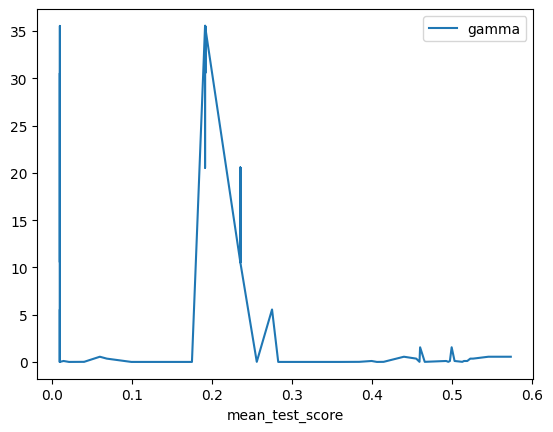

In [497]:
results_sv.plot(x = 'mean_test_score', y = 'gamma')